In [1]:
# Import library yang dibutuhkan
import json
import networkx as nx
import matplotlib.pyplot as plt

print("Library siap digunakan!")

Library siap digunakan!


In [2]:
def create_adjacency_graph_FINAL(metadata):
    """
    Fungsi FINAL untuk membuat adjacency graph.
    Menggunakan logika Bounding Box Overlap yang benar.
    """
    G = nx.Graph()
    tiles = metadata['image_tiles']
    
    # Asumsi PENTING:
    # Fungsi ini mengasumsikan bahwa 'position_x_um' dan 'position_y_um'
    # di metadatamu sebenarnya adalah posisi dalam satuan PIKSEL, bukan mikron.
    # Ini berdasarkan angka-angka yang kita lihat sebelumnya (misal, 1884px).
    
    # Tambahkan semua tile sebagai node, simpan data pentingnya
    for tile in tiles:
        G.add_node(
            tile['file_name'], 
            pos_x=tile['position_x_um'], 
            pos_y=tile['position_y_um'],
            width=tile['width_pixels'],
            height=tile['height_pixels']
        )
        
    # Iterasi untuk mencari tumpang tindih
    list_of_nodes = list(G.nodes(data=True))
    for i in range(len(list_of_nodes)):
        for j in range(i + 1, len(list_of_nodes)):
            # Ambil data node A dan B
            node_a_name, data_a = list_of_nodes[i]
            node_b_name, data_b = list_of_nodes[j]

            # LOGIKA DETEKSI OVERLAP YANG BENAR
            # Dua kotak tumpang tindih jika kondisi ini terpenuhi di kedua sumbu (X dan Y)
            x_overlap = (data_a['pos_x'] < data_b['pos_x'] + data_b['width']) and \
                        (data_a['pos_x'] + data_a['width'] > data_b['pos_x'])
            
            y_overlap = (data_a['pos_y'] < data_b['pos_y'] + data_b['height']) and \
                        (data_a['pos_y'] + data_a['height'] > data_b['pos_y'])

            # Jika tumpang tindih di kedua sumbu, buat koneksi
            if x_overlap and y_overlap:
                G.add_edge(node_a_name, node_b_name)
                
    return G

print("Fungsi 'create_adjacency_graph_FINAL' (versi paling benar) siap.")

Fungsi 'create_adjacency_graph_FINAL' (versi paling benar) siap.


In [3]:
# Pastikan nama file JSON sesuai dengan file sampeyan
nama_file_metadata = 'metadata.json' # <-- Ganti jika nama file beda

# Baca file metadata asli sampeyan
with open(nama_file_metadata, 'r') as f:
    loaded_metadata = json.load(f)

# Buat grafnya menggunakan FUNGSI YANG SUDAH DIPERBAIKI!
adjacency_graph = create_adjacency_graph_FINAL(loaded_metadata)

# Tampilkan informasi dasar tentang graf yang dihasilkan
print("Graf berhasil dibuat!")
print(f"Jumlah Node (tile): {adjacency_graph.number_of_nodes()}")
print(f"Jumlah Edge (hubungan): {adjacency_graph.number_of_edges()}")

# Opsional: Tampilkan beberapa edge pertama jika terlalu banyak
print("\nDaftar Edge (5 pertama):")
for i, edge in enumerate(adjacency_graph.edges()):
    if i >= 5:
        break
    print(edge)
    

Graf berhasil dibuat!
Jumlah Node (tile): 36
Jumlah Edge (hubungan): 107

Daftar Edge (5 pertama):
('tile_0_0.tif', 'tile_0_1.tif')
('tile_0_0.tif', 'tile_1_0.tif')
('tile_0_0.tif', 'tile_1_1.tif')
('tile_0_1.tif', 'tile_0_2.tif')
('tile_0_1.tif', 'tile_1_0.tif')


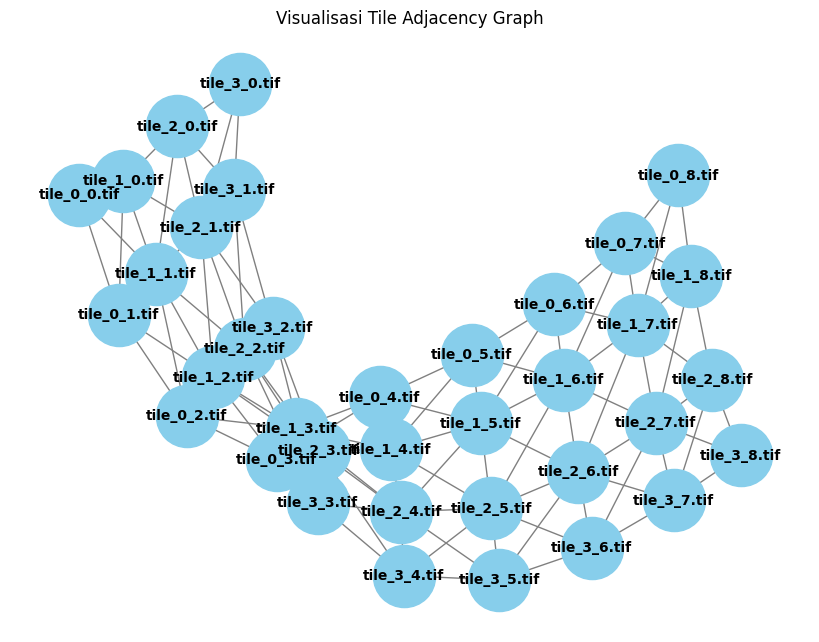

In [4]:
# Atur ukuran gambar agar lebih besar
plt.figure(figsize=(8, 6))

# Gambar grafnya
nx.draw(adjacency_graph, with_labels=True, node_color='skyblue', node_size=2000, font_size=10, font_weight='bold', edge_color='gray')

plt.title("Visualisasi Tile Adjacency Graph")
plt.show()

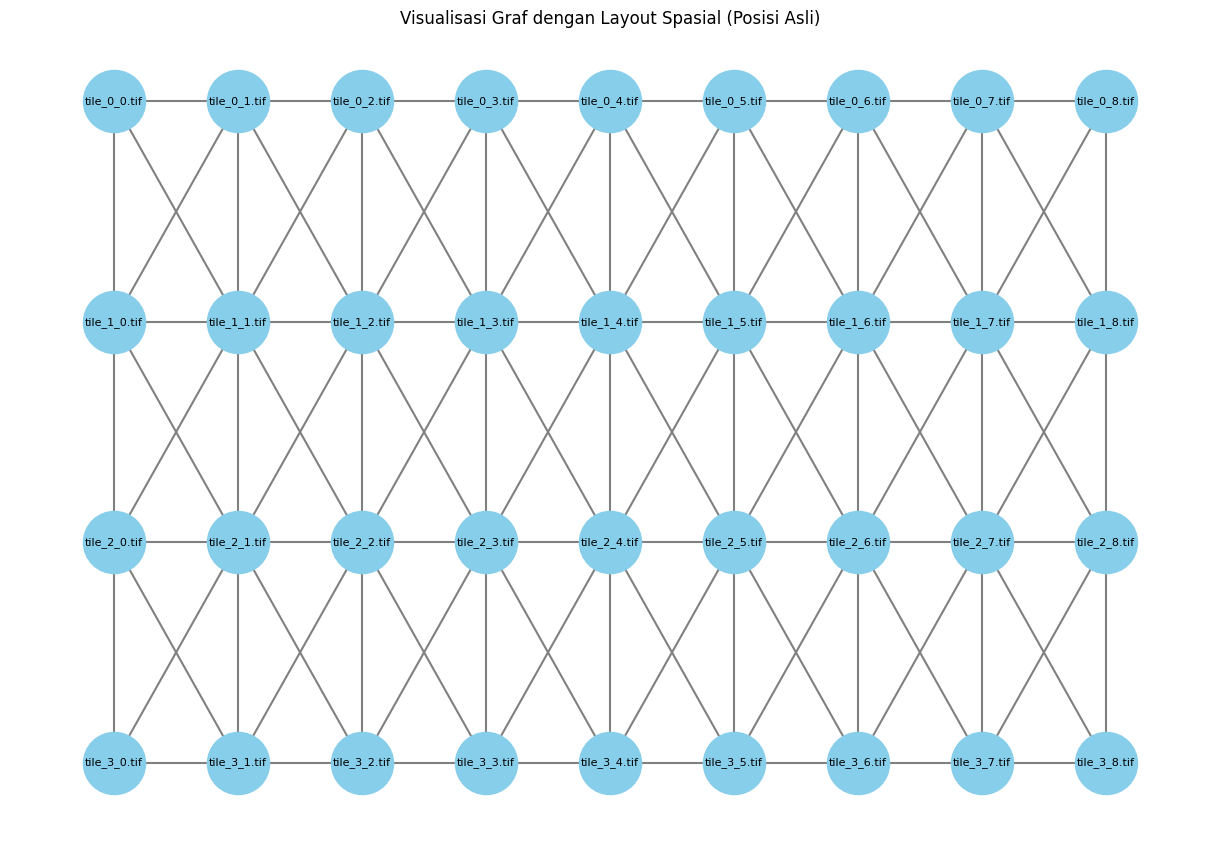

In [5]:
# 1. Membuat dictionary posisi dari atribut node yang sudah kita simpan
# Formatnya: {nama_node: (posisi_x, posisi_y)}
pos = {node: (data['pos_x'], data['pos_y']) 
       for node, data in adjacency_graph.nodes(data=True)}

# 2. Mengatur ukuran gambar agar lebih besar dan proporsional
plt.figure(figsize=(12, 8))

# 3. Menggambar graf dengan parameter 'pos'
nx.draw(adjacency_graph, 
        pos=pos,  # <-- INI KUNCINYA!
        with_labels=True, 
        node_color='skyblue', 
        node_size=2000, 
        font_size=8,
        width=1.5, # Lebar garis edge
        edge_color='gray')

# 4. (Penting) Membalik sumbu Y agar sesuai dengan layout gambar
# Biasanya (0,0) di plot ada di kiri bawah, sementara di gambar/stage ada di kiri atas
plt.gca().invert_yaxis()
plt.title("Visualisasi Graf dengan Layout Spasial (Posisi Asli)")
plt.show()

In [6]:
# Melanjutkan dari notebook sebelumnya...
# Library yang sudah ada: json, networkx, matplotlib.pyplot
# Library baru untuk tahap ini:
import os
import cv2
import numpy as np
from skimage.feature import match_template
import random
from tqdm import tqdm

print("Library tambahan untuk pemrosesan gambar siap.")

Library tambahan untuk pemrosesan gambar siap.


In [7]:
import itertools

def get_non_adjacent_pairs(graph, num_pairs):
    """Memilih pasangan node acak yang tidak terhubung di graf."""
    nodes = list(graph.nodes())
    existing_edges = set(graph.edges())
    
    non_adjacent_pairs = []
    # Loop untuk mencari pasangan yang tidak terhubung
    # Ini mungkin tidak efisien untuk graf sangat besar, tapi cukup untuk sekarang
    for pair in itertools.combinations(nodes, 2):
        # Pastikan urutan pair konsisten untuk pengecekan
        sorted_pair = tuple(sorted(pair))
        if sorted_pair not in existing_edges:
            non_adjacent_pairs.append(pair)
            
    # Ambil sampel acak dari semua pasangan yang tidak terhubung
    if len(non_adjacent_pairs) < num_pairs:
        print(f"Peringatan: Hanya ditemukan {len(non_adjacent_pairs)} pasangan non-adjacent.")
        return non_adjacent_pairs
    
    return random.sample(non_adjacent_pairs, num_pairs)

print("Fungsi get_non_adjacent_pairs siap.")

Fungsi get_non_adjacent_pairs siap.


In [8]:
import cv2
from skimage.feature import match_template
import numpy as np

def calculate_ncc_for_pair_FAST(tile1_path, tile2_path, scale_factor=0.25):
    """
    Versi CEPAT dari fungsi sebelumnya.
    Gambar akan dikecilkan terlebih dahulu (faktor 0.25 = 1/4 ukuran) sebelum dihitung NCC-nya.
    """
    try:
        image = cv2.imread(tile1_path, cv2.IMREAD_GRAYSCALE)
        template_full = cv2.imread(tile2_path, cv2.IMREAD_GRAYSCALE)

        if image is None or template_full is None:
            # Jika path folder salah, pastikan variabel IMAGE_FOLDER sudah benar
            return 0.0

        # --- OPTIMASI: Perkecil ukuran gambar ---
        small_image = cv2.resize(image, (0, 0), fx=scale_factor, fy=scale_factor, 
                                 interpolation=cv2.INTER_AREA)
        small_template_full = cv2.resize(template_full, (0, 0), fx=scale_factor, fy=scale_factor, 
                                         interpolation=cv2.INTER_AREA)
        
        # Ambil patch dari gambar yang sudah dikecilkan
        h, w = small_template_full.shape
        ph, pw = h // 4, w // 4
        template_patch = small_template_full[ph:h-ph, pw:w-pw]

        result = match_template(small_image, template_patch)
        
        return np.max(result)

    except Exception as e:
        return 0.0

print("Fungsi CEPAT 'calculate_ncc_for_pair_FAST' siap.")

Fungsi CEPAT 'calculate_ncc_for_pair_FAST' siap.


In [9]:
import time

NUM_PAIRS_FOR_TEST = 1000
IMAGE_FOLDER = r'D:\Stitch\bilinear_stitching_20250929_093751'

# Pastikan variabel 'adjacency_graph' dan 'IMAGE_FOLDER' sudah benar
# IMAGE_FOLDER harus berisi path ke gambar aslimu, misal 'data_mikroskop'

# Kita akan menyimpan hasil ke variabel baru
ncc_scores_fast = []
# Menggunakan bad_pairs yang sama dari sebelumnya (630 pasangan)

bad_pairs = get_non_adjacent_pairs(adjacency_graph, NUM_PAIRS_FOR_TEST)

print(f"Menghitung skor NCC untuk {len(bad_pairs)} pasangan (versi CEPAT)...")

# Mulai hitung waktu
start_time = time.time()

for pair in tqdm(bad_pairs):
    path1 = os.path.join(IMAGE_FOLDER, pair[0])
    path2 = os.path.join(IMAGE_FOLDER, pair[1])
    
    score = calculate_ncc_for_pair_FAST(path1, path2) 
    ncc_scores_fast.append(score)

# Selesai hitung waktu
end_time = time.time()
time_fast_res_seconds = end_time - start_time

print("Perhitungan skor versi CEPAT selesai.")

# Hitung threshold dan simpan di variabel baru
threshold_fast = np.percentile(ncc_scores_fast, 99)

print("\n--- HASIL (VERSI CEPAT) ---")
print(f"Waktu Eksekusi: {time_fast_res_seconds:.2f} detik")
print(f"Ambang Batas NCC (Persentil ke-99) adalah: {threshold_fast:.4f}")

Peringatan: Hanya ditemukan 523 pasangan non-adjacent.
Menghitung skor NCC untuk 523 pasangan (versi CEPAT)...


100%|██████████| 523/523 [02:32<00:00,  3.42it/s]

Perhitungan skor versi CEPAT selesai.

--- HASIL (VERSI CEPAT) ---
Waktu Eksekusi: 153.02 detik
Ambang Batas NCC (Persentil ke-99) adalah: 0.9506


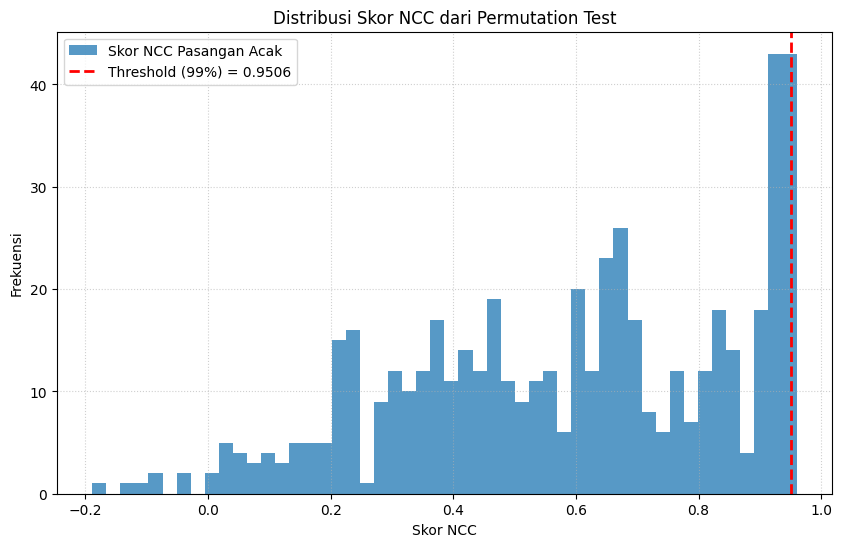

In [10]:
if ncc_scores_fast:
    plt.figure(figsize=(10, 6))
    plt.hist(ncc_scores_fast, bins=50, alpha=0.75, label='Skor NCC Pasangan Acak')
    plt.axvline(threshold_fast, color='r', linestyle='--', linewidth=2, label=f'Threshold (99%) = {threshold_fast:.4f}')
    
    plt.title('Distribusi Skor NCC dari Permutation Test')
    plt.xlabel('Skor NCC')
    plt.ylabel('Frekuensi')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()

In [11]:
from skimage.registration import phase_cross_correlation

# Gunakan threshold yang kita dapat dari eksperimen versi cepat
NCC_THRESHOLD = 0.80

# Batas toleransi pergeseran dalam piksel (setelah di-downsample)
# Jika pergeserannya lebih dari ini, kita anggap aneh dan kita buang.
# Nilai ini bisa disesuaikan, tapi 50px untuk gambar downsampled sudah cukup besar.
TRANSLATION_LIMIT_PIXELS = 50 

print(f"Threshold yang akan digunakan: {NCC_THRESHOLD:.4f}")
print(f"Batas toleransi pergeseran: {TRANSLATION_LIMIT_PIXELS} piksel")

Threshold yang akan digunakan: 0.8000
Batas toleransi pergeseran: 50 piksel


In [12]:
def align_and_score_pair(tile1_path, tile2_path, scale_factor=0.25):
    """
    Fungsi ini melakukan 3 hal:
    1. Mencari pergeseran (translation) terbaik menggunakan phase cross-correlation.
    2. Menghitung skor NCC.
    3. Mengembalikan kedua hasil tersebut.
    """
    try:
        image1 = cv2.imread(tile1_path, cv2.IMREAD_GRAYSCALE)
        image2 = cv2.imread(tile2_path, cv2.IMREAD_GRAYSCALE)

        if image1 is None or image2 is None:
            return {'ncc_score': 0.0, 'translation_px': (0, 0)}

        # Perkecil gambar untuk kecepatan
        small_image1 = cv2.resize(image1, (0, 0), fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_AREA)
        small_image2 = cv2.resize(image2, (0, 0), fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_AREA)
        
        # 1. Cari pergeseran (dy, dx) dengan phase correlation
        # dy, dx adalah pergeseran dalam piksel di skala gambar yang sudah dikecilkan
        shift, _, _ = phase_cross_correlation(small_image1, small_image2, upsample_factor=10)
        dy, dx = shift
        
        # 2. Hitung skor NCC (menggunakan metode template matching seperti sebelumnya)
        h, w = small_image2.shape
        template_patch = small_image2[h//4:h-h//4, w//4:w-w//4]
        result = match_template(small_image1, template_patch)
        ncc_score = np.max(result)
        
        return {'ncc_score': ncc_score, 'translation_px': (dy, dx)}

    except Exception as e:
        return {'ncc_score': 0.0, 'translation_px': (0, 0)}

print("Fungsi 'align_and_score_pair' siap.")

Fungsi 'align_and_score_pair' siap.


In [13]:
# PENTING: Pastikan adjacency_graph di-reset ke kondisi awal (107 koneksi)
# Jalankan lagi sel dari Tahap 1.1: adjacency_graph = create_adjacency_graph_FINAL(loaded_metadata)
print("Pastikan adjacency_graph sudah di-reset ke kondisi awal (107 koneksi).")
initial_edge_count = adjacency_graph.number_of_edges()
print(f"Jumlah koneksi awal untuk dihitung: {initial_edge_count}")


# Kita akan iterasi dan menyimpan hasil di setiap edge
for u, v in tqdm(adjacency_graph.edges(), desc="Calculating Shifts"):
    path1 = os.path.join(IMAGE_FOLDER, u)
    path2 = os.path.join(IMAGE_FOLDER, v)
    
    # Kita pakai fungsi yang paling simpel, hanya butuh pergeseran & skor
    # Kita bisa gunakan align_score_complexity atau align_and_score_pair
    result = align_and_score_pair(path1, path2) # Pakai fungsi dari Tahap 1.3 sebelumnya

    if result:
        score = result['ncc_score']
        dy, dx = result['translation_px']
        
        # SIMPAN HASILNYA, JANGAN HAPUS APAPUN
        adjacency_graph.edges[u, v]['encc'] = -np.log(score) if score > 0 else float('inf')
        adjacency_graph.edges[u, v]['translation'] = (dy, dx)
        adjacency_graph.edges[u, v]['ncc'] = score
        
print("\n--- PERHITUNGAN PERGESERAN SELESAI ---")
print("Semua 107 koneksi sekarang memiliki data pergeseran yang presisi.")

Pastikan adjacency_graph sudah di-reset ke kondisi awal (107 koneksi).
Jumlah koneksi awal untuk dihitung: 107


Calculating Shifts: 100%|██████████| 107/107 [00:40<00:00,  2.67it/s]


--- PERHITUNGAN PERGESERAN SELESAI ---
Semua 107 koneksi sekarang memiliki data pergeseran yang presisi.


In [14]:
# Temukan semua komponen (pulau) yang terhubung di dalam graf
# adjacency_graph adalah hasil dari Tahap 1.3
connected_components = list(nx.connected_components(adjacency_graph))

print(f"Ditemukan {len(connected_components)} buah 'pulau' (komponen) yang terpisah.")

# Tampilkan isi dari setiap pulau (daftar nama file-nya)
for i, component in enumerate(connected_components):
    print(f"  - Pulau {i+1}: berisi {len(component)} tile")

Ditemukan 1 buah 'pulau' (komponen) yang terpisah.
  - Pulau 1: berisi 36 tile


In [15]:
# Dictionary untuk menyimpan semua posisi final yang sudah dikoreksi
final_positions = {}

print("Memulai proses perhitungan posisi presisi untuk setiap pulau...")

# Loop untuk setiap pulau
for i, component in enumerate(connected_components):
    # Buat subgraf yang hanya berisi node & edge dari pulau ini
    subgraph = adjacency_graph.subgraph(component)
    
    # 1. Buat Minimum Spanning Tree (MST) dari subgraf
    # Bobotnya menggunakan 'encc' (error NCC), di mana nilai terkecil lebih disukai
    mst = nx.minimum_spanning_tree(subgraph, weight='encc')
    
    # Tentukan satu tile sebagai titik awal (akar) dari pohon ini
    root = list(component)[0]
    
    # Dictionary untuk posisi di dalam pulau ini
    # Posisi root kita anggap (0,0) sebagai titik referensi
    relative_positions = {root: (0.0, 0.0)}
    
    # 2. "Berjalan" di sepanjang pohon (MST) menggunakan Breadth-First Search (BFS)
    # untuk menghitung posisi tile lainnya
    for edge in nx.bfs_edges(mst, source=root):
        parent, child = edge
        
        # Ambil data pergeseran (dy, dx) dari edge
        dy, dx = mst.edges[parent, child]['translation']
        
        # Posisi parent (yang sudah dihitung sebelumnya)
        parent_pos_y, parent_pos_x = relative_positions[parent]
        
        # Hitung posisi child berdasarkan posisi parent + pergeseran
        child_pos_y = parent_pos_y + dy
        child_pos_x = parent_pos_x + dx
        
        # Simpan posisi child
        relative_positions[child] = (child_pos_y, child_pos_x)
        
    # Tambahkan semua posisi yang baru dihitung dari pulau ini ke dictionary utama
    final_positions.update(relative_positions)
    print(f"  - Pulau {i+1} selesai diproses.")

print("\n--- PERHITUNGAN POSISI SELESAI ---")
print(f"Total {len(final_positions)} tile berhasil dihitung posisinya.")

# Tampilkan beberapa contoh hasilnya
print("\nContoh hasil posisi presisi (y, x) dalam piksel (skala kecil):")
for i, (tile_name, pos) in enumerate(final_positions.items()):
    if i >= 5: # Tampilkan 5 pertama saja
        break
    print(f"  - {tile_name}: ({pos[0]:.2f}, {pos[1]:.2f})")

Memulai proses perhitungan posisi presisi untuk setiap pulau...
  - Pulau 1 selesai diproses.

--- PERHITUNGAN POSISI SELESAI ---
Total 36 tile berhasil dihitung posisinya.

Contoh hasil posisi presisi (y, x) dalam piksel (skala kecil):
  - tile_2_5.tif: (0.00, 0.00)
  - tile_3_4.tif: (0.00, 0.00)
  - tile_3_5.tif: (0.00, 0.00)
  - tile_3_3.tif: (0.00, 0.00)
  - tile_2_4.tif: (0.00, 0.00)


In [16]:
from sklearn.linear_model import LinearRegression
import numpy as np

print("Library scikit-learn siap digunakan.")

Library scikit-learn siap digunakan.


In [17]:
# Pastikan variabel-variabel ini masih ada dari tahap sebelumnya:
# - connected_components: Daftar 'pulau'
# - final_positions: Posisi presisi relatif di dalam setiap pulau
# - loaded_metadata: Metadata asli dari file JSON

# 1. Cari pulau terbesar untuk dijadikan 'data pelatihan'
# Kita anggap pulau terbesar punya data paling representatif
anchor_component = max(connected_components, key=len)
print(f"Menggunakan pulau dengan {len(anchor_component)} tile sebagai 'anchor' untuk pelatihan model.")

# Buat dictionary untuk mempermudah pencarian metadata
metadata_map = {tile['file_name']: tile for tile in loaded_metadata['image_tiles']}

# 2. Siapkan data pelatihan dari 'pulau anchor'
initial_coords = [] # Posisi kasar dari metadata (Input Fitur, X)
final_rel_coords = [] # Posisi presisi dari Tahap 1.4 (Output Target, y)

for tile_name in anchor_component:
    initial_pos = metadata_map[tile_name]
    final_pos = final_positions[tile_name]
    
    initial_coords.append([initial_pos['position_y_um'], initial_pos['position_x_um']])
    final_rel_coords.append([final_pos[0], final_pos[1]])

# Konversi ke NumPy array agar bisa dibaca scikit-learn
initial_coords = np.array(initial_coords)
final_rel_coords = np.array(final_rel_coords)

# 3. Latih dua model regresi linear
# Satu untuk memprediksi posisi Y, satu lagi untuk memprediksi posisi X
model_y = LinearRegression()
model_x = LinearRegression()

model_y.fit(initial_coords, final_rel_coords[:, 0]) # Latih model Y
model_x.fit(initial_coords, final_rel_coords[:, 1]) # Latih model X

print("Model regresi linear berhasil dilatih.")

# 4. Gunakan model untuk memprediksi posisi ABSOLUT untuk SEMUA tile
absolute_final_positions = {}
all_tiles_in_islands = list(final_positions.keys())

for tile_name in all_tiles_in_islands:
    # Ambil posisi kasar dari metadata
    initial_pos = metadata_map[tile_name]
    initial_coord_single = np.array([[initial_pos['position_y_um'], initial_pos['position_x_um']]])
    
    # Prediksi posisi presisi global menggunakan model yang sudah pintar
    predicted_y = model_y.predict(initial_coord_single)
    predicted_x = model_x.predict(initial_coord_single)
    
    absolute_final_positions[tile_name] = (predicted_y[0], predicted_x[0])

print("\n--- POSISI GLOBAL FINAL BERHASIL DIHITUNG ---")
print("Ini adalah hasil akhir posisi presisi untuk semua tile dalam satu panggung.")
print("\nContoh hasil (y, x) dalam piksel (skala kecil):")
for i, (tile_name, pos) in enumerate(absolute_final_positions.items()):
    if i >= 5: # Tampilkan 5 pertama saja
        break
    print(f"  - {tile_name}: ({pos[0]:.2f}, {pos[1]:.2f})")

Menggunakan pulau dengan 36 tile sebagai 'anchor' untuk pelatihan model.
Model regresi linear berhasil dilatih.

--- POSISI GLOBAL FINAL BERHASIL DIHITUNG ---
Ini adalah hasil akhir posisi presisi untuk semua tile dalam satu panggung.

Contoh hasil (y, x) dalam piksel (skala kecil):
  - tile_2_5.tif: (3.34, -133.24)
  - tile_3_4.tif: (0.20, -12.19)
  - tile_3_5.tif: (0.45, -22.92)
  - tile_3_3.tif: (-0.06, -1.46)
  - tile_2_4.tif: (3.08, -122.51)


In [18]:
import time

def render_mosaic(final_positions, metadata_map, image_folder, scale_factor=0.25):
    """
    Merakit semua tile menjadi satu gambar mosaic utuh berdasarkan posisi final.
    """
    print("Memulai tahap rendering...")
    
    # PERINGATAN PENTING:
    # Posisi yang kita hitung (final_positions) adalah dalam skala kecil (downsampled).
    # Kita harus mengembalikannya ke skala resolusi penuh.
    # Nilai scale_factor HARUS SAMA dengan yang digunakan di fungsi FAST.
    inv_scale = 1 / scale_factor

    # 1. Hitung ukuran kanvas total dalam resolusi PENUH
    min_x, max_x = float('inf'), float('-inf')
    min_y, max_y = float('inf'), float('-inf')

    for tile_name, (y, x) in final_positions.items():
        # Kembalikan posisi ke skala asli
        y_full = y * inv_scale
        x_full = x * inv_scale
        
        # Ambil ukuran tile dari metadata
        tile_meta = metadata_map[tile_name]
        width = tile_meta['width_pixels']
        height = tile_meta['height_pixels']
        
        min_x = min(min_x, x_full)
        min_y = min(min_y, y_full)
        max_x = max(max_x, x_full + width)
        max_y = max(max_y, y_full + height)

    # Bulatkan dan hitung ukuran final kanvas
    canvas_width = int(round(max_x - min_x))
    canvas_height = int(round(max_y - min_y))
    
    print(f"Ukuran kanvas final: {canvas_width} x {canvas_height} piksel.")
    
    # 2. Buat kanvas kosong (BGR 3 channel)
    # Kita pakai uint8 (0-255) karena gambar kita formatnya itu
    final_mosaic = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)
    
    # 3. Loop dan 'tempel' setiap tile
    for tile_name, (y, x) in tqdm(final_positions.items(), desc="Rendering Tiles"):
        # Baca gambar ASLI (resolusi penuh)
        img_path = os.path.join(image_folder, tile_name)
        tile_image = cv2.imread(img_path) # imread membaca sebagai BGR
        
        if tile_image is None:
            continue
        
        # Kembalikan posisi ke skala asli
        y_full = y * inv_scale
        x_full = x * inv_scale
        
        # Hitung posisi tempel di kanvas (koordinat pojok kiri atas)
        # Kurangi dengan min_x/y agar semuanya positif
        paste_y = int(round(y_full - min_y))
        paste_x = int(round(x_full - min_x))
        
        h, w, _ = tile_image.shape
        
        # Tempelkan gambar ke kanvas menggunakan slicing NumPy
        # Ini metode paling simpel (overwrite), belum ada blending
        final_mosaic[paste_y:paste_y+h, paste_x:paste_x+w] = tile_image
        
    return final_mosaic

print("Fungsi 'render_mosaic' siap.")

Fungsi 'render_mosaic' siap.


Memulai tahap rendering...
Ukuran kanvas final: 4115 x 2091 piksel.


Rendering Tiles: 100%|██████████| 36/36 [00:02<00:00, 13.93it/s]



Proses rendering selesai dalam 2.59 detik.
Menyimpan hasil ke file 'mosaic_final.png'...
Berhasil!

Membuat preview untuk ditampilkan...


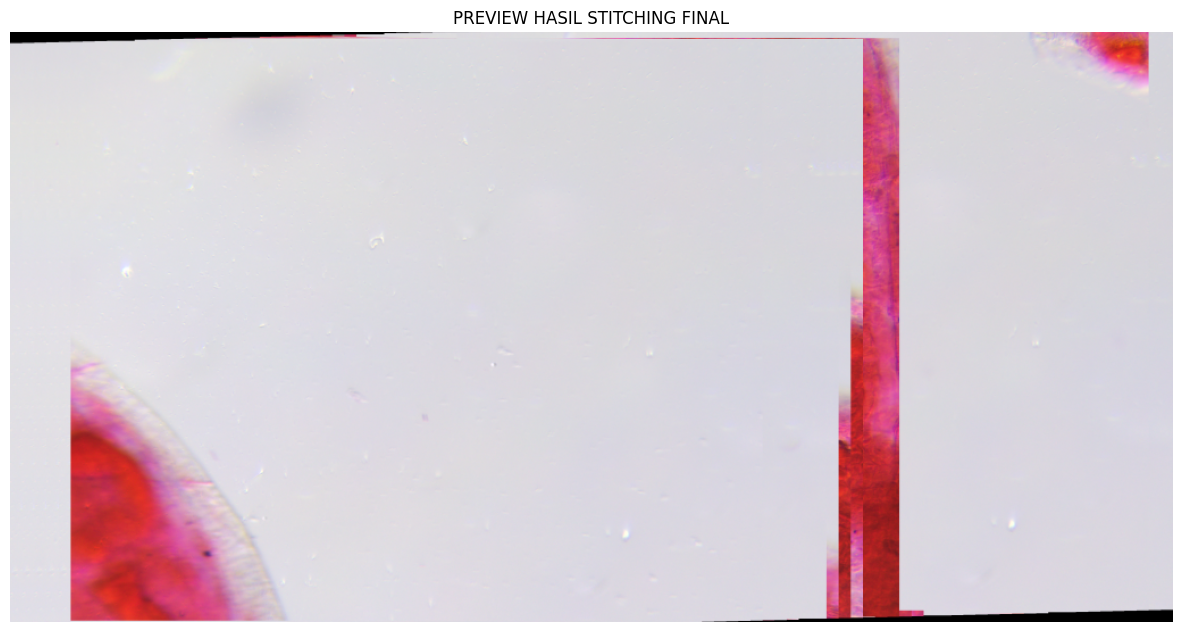

In [19]:
# Pastikan semua variabel ini ada: absolute_final_positions, metadata_map, IMAGE_FOLDER
start_render_time = time.time()

# Panggil fungsi rendering
# Pastikan scale_factor sama dengan yang dipakai di fungsi FAST
final_image = render_mosaic(absolute_final_positions, metadata_map, IMAGE_FOLDER, scale_factor=0.25)

end_render_time = time.time()
print(f"\nProses rendering selesai dalam {end_render_time - start_render_time:.2f} detik.")

# 4. Simpan hasilnya ke file
output_filename = 'mosaic_final.png'
print(f"Menyimpan hasil ke file '{output_filename}'...")
cv2.imwrite(output_filename, final_image)
print("Berhasil!")

# --- Tampilkan Preview ---
# Gambar aslinya terlalu besar untuk ditampilkan langsung di notebook.
# Kita buat versi kecilnya untuk preview.
print("\nMembuat preview untuk ditampilkan...")
preview_width = 1024 # Lebar preview dalam piksel
aspect_ratio = final_image.shape[0] / final_image.shape[1]
preview_height = int(preview_width * aspect_ratio)
preview_image = cv2.resize(final_image, (preview_width, preview_height), interpolation=cv2.INTER_AREA)

# Konversi warna dari BGR (OpenCV) ke RGB (Matplotlib) agar warnanya benar
preview_image_rgb = cv2.cvtColor(preview_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 15))
plt.imshow(preview_image_rgb)
plt.title('PREVIEW HASIL STITCHING FINAL')
plt.axis('off')
plt.show()

In [22]:
import numpy as np
from PIL import Image
from tifffile import imread

img = imread("img-stitched-0.ome.tif")

# Normalisasi 16-bit ke 8-bit
img8 = (img / img.max() * 255).astype('uint8')

Image.fromarray(img8).save("output.png")


In [8]:
import numpy as np
from skimage import io, exposure
from skimage.registration import phase_cross_correlation
from scipy.ndimage import fourier_shift
import os
import glob
from tqdm.notebook import tqdm
import tkinter as tk
from tkinter import filedialog

# ===================================================================
# BAGIAN KONFIGURASI (Ubah parameter di sini jika perlu)
# ===================================================================
rows = 4  # Jumlah baris grid gambarmu
cols = 9  # Jumlah kolom grid gambarmu

# Pola nama file. {r} akan diganti dengan nomor baris, {c} dengan nomor kolom.
# Sesuaikan dengan nama file-mu. Contoh: 'tile_R{r}_C{c}.tif', 'image-r{r}-c{c}.png'
file_pattern = "tile_{r:02d}_{c:02d}.png"

# Apakah mau melakukan normalisasi gambar? (membantu jika ada perbedaan pencahayaan)
use_normalization = False

# Nama file output
output_filename = "stitched_result_final.tif"
# ===================================================================


# --- Mulai Logika Program ---

# 1. Munculkan dialog untuk memilih folder
print("Silakan pilih folder yang berisi file-file gambar tile...")
root = tk.Tk()
root.withdraw()  # Sembunyikan jendela utama tkinter
image_dir = r"D:\Stitch\bilinear_stitching_20250915_152529"

if not image_dir:
    print("Folder tidak dipilih. Program berhenti.")
else:
    print(f"Folder yang dipilih: {image_dir}")

    # 2. Verifikasi file dan baca dimensi tile (VERSI PERBAIKAN)
    try:
        # Buat pola pencarian sederhana untuk glob
        glob_pattern = "tile_*_*.png"
        
        # Cari semua file yang cocok dengan pola tersebut
        found_files = glob.glob(os.path.join(image_dir, glob_pattern))
        
        # Cek apakah ada file yang ditemukan
        if not found_files:
            raise IndexError # Lemparkan error jika tidak ada file sama sekali
            
        # Ambil path file pertama dari daftar yang ditemukan
        first_file_path = found_files[0]
        
        # Baca gambar pertama untuk mendapatkan dimensinya
        first_image = io.imread(first_file_path)
        tile_h, tile_w = first_image.shape[:2]
        print(f"Dimensi tile terdeteksi: Tinggi={tile_h}, Lebar={tile_w}")
        
    except IndexError:
        print(f"ERROR: Tidak ada file yang cocok dengan pola '{file_pattern}' di folder '{image_dir}'.")
        print("Pastikan nama folder dan pola nama file di konfigurasi sudah benar.")
        
    else:
        # 3. Muat semua tile ke dalam memori
        print("\nMemuat semua gambar tile...")
        tiles = [[None for c in range(cols)] for r in range(rows)]
        for r in tqdm(range(rows), desc="Loading Rows"):
            for c in range(cols):
                filepath = os.path.join(image_dir, file_pattern.format(r=r, c=c))
                tiles[r][c] = io.imread(filepath)

        # 4. (Opsional) Normalisasi
        if use_normalization:
            print("\nMelakukan normalisasi gambar (Adaptive Histogram Equalization)...")
            for r in tqdm(range(rows), desc="Normalizing"):
                for c in range(cols):
                    # Cek jika gambar berwarna
                    if tiles[r][c].ndim == 3:
                        # Lakukan pada setiap channel warna
                        for channel in range(tiles[r][c].shape[2]):
                           tiles[r][c][:,:,channel] = exposure.equalize_adapthist(tiles[r][c][:,:,channel])
                    else:
                        tiles[r][c] = exposure.equalize_adapthist(tiles[r][c])

        # 5. Hitung pergeseran relatif antar tile
        print("\nMenghitung pergeseran presisi antar tile...")
        shifts = np.zeros((rows, cols, 2))  # Menyimpan pergeseran absolut (y, x)
        
        # Propagasi pergeseran dari tile (0,0)
        for r in tqdm(range(rows), desc="Calculating Shifts"):
            for c in range(cols):
                if r == 0 and c == 0:
                    continue  # Tile pertama adalah anchor di (0,0)

                # Blok Kode BARU
                if c > 0:  # Align dengan tetangga kiri
                    from skimage.color import rgb2gray # Import fungsi konversi
    
                    # Pastikan gambar adalah 2D (grayscale) sebelum diproses
                    img_a = tiles[r][c-1]
                    if img_a.ndim == 3: img_a = rgb2gray(img_a)
    
                    img_b = tiles[r][c]
                    if img_b.ndim == 3: img_b = rgb2gray(img_b)

                    shift, _, _ = phase_cross_correlation(img_a, img_b, upsample_factor=10)
                    # Akumulasi pergeseran dari tetangga kiri
                    shifts[r, c] = shifts[r, c-1] + shift
                # Blok Kode BARU
                elif r > 0 and c == 0:  # Tile di kolom pertama, align dengan tetangga atas
                    from skimage.color import rgb2gray # Import lagi (tidak apa-apa)

                    # Pastikan gambar adalah 2D (grayscale) sebelum diproses
                    img_a = tiles[r-1][c]
                    if img_a.ndim == 3: img_a = rgb2gray(img_a)
    
                    img_b = tiles[r][c]
                    if img_b.ndim == 3: img_b = rgb2gray(img_b)

                    shift, _, _ = phase_cross_correlation(img_a, img_b, upsample_factor=10)
                    # Akumulasi pergeseran dari tetangga atas
                    shifts[r, c] = shifts[r-1, c] + shift
        
        # 6. Render mosaic
        print("\nMembuat gambar mosaic final...")
        
        # Balik urutan y,x dari phase_correlation ke x,y untuk posisi
        shifts_xy = shifts[:,:,::-1]
        
        # Hitung ukuran kanvas
        xs = shifts_xy[:,:,0].ravel()
        ys = shifts_xy[:,:,1].ravel()
        min_x, min_y = int(np.floor(xs.min())), int(np.floor(ys.min()))
        max_x, max_y = int(np.ceil(xs.max() + tile_w)), int(np.ceil(ys.max() + tile_h))
        canvas_w, canvas_h = max_x - min_x, max_y - min_y

        # Cek apakah gambar berwarna atau grayscale
        is_color = tiles[0][0].ndim == 3
        if is_color:
            canvas = np.zeros((canvas_h, canvas_w, tiles[0][0].shape[2]), dtype=np.float32)
        else:
            canvas = np.zeros((canvas_h, canvas_w), dtype=np.float32)

        weight = np.zeros((canvas_h, canvas_w), dtype=np.float32)

        for r in tqdm(range(rows), desc="Rendering Tiles"):
            for c in range(cols):
                x = int(round(shifts_xy[r,c,0] - min_x))
                y = int(round(shifts_xy[r,c,1] - min_y))
                tile = tiles[r][c]
                
                # Blending dengan metode averaging sederhana
                h, w = tile.shape[:2]
                if is_color:
                    canvas[y:y+h, x:x+w, :] += tile
                    weight[y:y+h, x:x+w] += 1.0
                else:
                    canvas[y:y+h, x:x+w] += tile
                    weight[y:y+h, x:x+w] += 1.0

        # Hindari pembagian dengan nol
        weight[weight == 0] = 1.0
        
        if is_color:
            output = canvas / weight[:,:,np.newaxis]
            output = output.astype(tiles[0][0].dtype)
        else:
            output = canvas / weight
            output = output.astype(tiles[0][0].dtype)
            
        # 7. Simpan hasil
        print(f"\nMenyimpan hasil akhir ke '{output_filename}'...")
        io.imsave(output_filename, output)
        print("SELESAI!")

Silakan pilih folder yang berisi file-file gambar tile...
Folder yang dipilih: D:\Stitch\bilinear_stitching_20250915_152529
Dimensi tile terdeteksi: Tinggi=2048, Lebar=2448

Memuat semua gambar tile...


Loading Rows:   0%|          | 0/4 [00:00<?, ?it/s]


Menghitung pergeseran presisi antar tile...


Calculating Shifts:   0%|          | 0/4 [00:00<?, ?it/s]


Membuat gambar mosaic final...


Rendering Tiles:   0%|          | 0/4 [00:00<?, ?it/s]


Menyimpan hasil akhir ke 'stitched_result_final.tif'...
SELESAI!
